In [1]:
import MetaTrader5 as mt5
import pandas as pd
from datetime import datetime
import time
import talib as ta
import matplotlib.pyplot as plt

In [2]:
def market_order(symbol, volume, order_type):

    if order_type == 'buy':
        price = mt5.symbol_info_tick(symbol).ask
        request = {
            "action": mt5.TRADE_ACTION_DEAL,
            "symbol": symbol,
            "volume": volume,
            "type": mt5.ORDER_TYPE_BUY,
            "price": price,
            "sl": price-0.0003, #最小單位
            "tp": price+0.0003,
            "deviation": 20,
            "magic": 110357017,
            "comment": "python market order",
            "type_time": mt5.ORDER_TIME_GTC,
            "type_filling": mt5.ORDER_FILLING_IOC,
            }
    elif order_type == 'sell':
        price = mt5.symbol_info_tick(symbol).bid
        request = {
            "action": mt5.TRADE_ACTION_DEAL,
            "symbol": symbol,
            "volume": volume,
            "type": mt5.ORDER_TYPE_SELL,
            "price": price,
            "sl": price+0.0003,
            "tp": price-0.0003,
            "deviation": 20,
            "magic": 110357017,
            "comment": "python market order",
            "type_time": mt5.ORDER_TIME_GTC,
            "type_filling": mt5.ORDER_FILLING_IOC,
            }
    order_result = mt5.order_send(request)
    
    print(order_result)

    return order_result

In [3]:
def get_exposure(symbol):
    positions = mt5.positions_get(symbol=symbol)
    if positions:
        pos_df = pd.DataFrame(positions, columns=positions[0]._asdict().keys())
        pos_df['time'] = pd.to_datetime(pos_df['time'], unit='s')
        exposure = pos_df[[ 'symbol', 'type', 'volume', 'profit']]

        return exposure

In [4]:
def signal_mom(symbol, timeframe, mom_line, mom_fast, mom_slow):
    x = mt5.copy_rates_from_pos(symbol, timeframe, 0, 1000)
    df_mom = pd.DataFrame(x)

    last_close = df_mom.iloc[-1].close

    mom = ta.MOM(df_mom.close, mom_line)
    mom_fast_line = ta.TEMA(mom, mom_fast)
    mom_slow_line = ta.TEMA(mom, mom_slow)

    direction = 'flat'
    if ((mom_fast_line.iloc[-1] > mom_slow_line.iloc[-1]) & (mom_fast_line.iloc[-2] < mom_slow_line.iloc[-2])) :
        direction = 'buy'
    elif ((mom_fast_line.iloc[-1] < mom_slow_line.iloc[-1]) & (mom_fast_line.iloc[-2] > mom_slow_line.iloc[-2])) :
        direction = 'sell'

    return last_close, direction



In [5]:
def signal(symbol, timeframe, sma_fast, sma_slow):
    bars = mt5.copy_rates_from_pos(symbol, timeframe, 0, 1000)
    bars_df = pd.DataFrame(bars)

    #SMA
    fast_line = ta.SMA(bars_df.close, sma_fast)
    slow_line = ta.SMA(bars_df.close, sma_slow)

    #MACD [0]DIF [1]MACD [2]diff
    MACD = ta.MACD(bars_df.close)

    last_close = bars_df.iloc[-1].close
    global direction_sma
    global direction_macd

    direction = 'flat'
    direction_macd = 'flat'
    
    if ((fast_line.iloc[-1] > slow_line.iloc[-1]) & (fast_line.iloc[-2] < slow_line.iloc[-2])) :
        direction_sma = 'buy'
    if (MACD[0].iloc[-2] <0) & (MACD[0].iloc[-1] >0):
        direction_macd = 'buy'

    if ((fast_line.iloc[-1] < slow_line.iloc[-1]) & (fast_line.iloc[-2] > slow_line.iloc[-2])) :
        direction_sma = 'sell'
    if (MACD[0].iloc[-2] >0) & (MACD[0].iloc[-1] <0):
        direction_macd = 'sell'
    
    if (direction_sma == 'buy') & (direction_macd == 'buy'):
        direction = 'buy'
    if (direction_sma == 'sell') & (direction_macd == 'sell'):
        direction = 'sell'

    return last_close, direction, direction_sma, direction_macd


In [6]:
def trailstlp(symbol):
    df = mt5.positions_get(symbol=symbol)

    price=mt5.symbol_info_tick(symbol)
    
    if df:
        
        for data in df:
            if (data.type == 0) & (price.bid > data.price_open) & (price.bid > (data.sl+0.0002)) : #buy

                new_sl = price.bid - 0.0002
                new_tp = price.bid + 0.0005
                request = {
                    "action": mt5.TRADE_ACTION_SLTP,
                    "position": int(data.ticket),
                    "symbol": data.symbol,
                    "sl": new_sl,
                    "tp": new_tp,
                    "magic": 234000,
                    "comment": "python script",
                }

                order_result = mt5.order_send(request)
                
                print("執行結果", order_result[7])

            elif (data.type == 1) & (price.ask < data.price_open) & (price.ask < (data.sl-0.0002)) : #sell

                new_sl = price.ask + 0.0002
                new_tp = price.ask - 0.0005
                request = {
                    "action": mt5.TRADE_ACTION_SLTP,
                    "position": int(data.ticket),
                    "symbol": data.symbol,
                    "sl": new_sl,
                    "tp": new_tp,
                    "magic": 234000,
                    "comment": "python script",
                }

                order_result = mt5.order_send(request)
                
                print("執行結果", order_result[7])
    return 0

### 主程式

In [ ]:
mt5.initialize()

In [ ]:
direction_sma = None
direction_macd = None

symbols_list = {
    "EURUSD": ["EURUSD", 0.1],
    "GBPUSD": ["GBPUSD", 0.1],
    "AUDCAD": ["AUDCAD", 0.1],
    "AUDCHF": ["AUDCHF", 0.1],
    "AUDNZD": ["AUDNZD", 0.1],
    "EURAUD": ["EURAUD", 0.1],
    "EURCAD": ["EURCAD", 0.1],
}
while True:

    for asset in symbols_list.keys():
        symbol = symbols_list[asset][0]
        volume = symbols_list[asset][1]

        timeframe = mt5.TIMEFRAME_M5
        sma_fast = 5
        sma_slow = 20
        #mom_line = 135
        #mom_fast = 5
        #mom_slow = 15

        exposure = get_exposure(symbol)

        last_close, direction, direction_sma, direction_macd = signal(symbol, timeframe, sma_fast, sma_slow)
        #last_close, direction = signal_mom(symbol, timeframe, mom_line, mom_fast, mom_slow)

        if direction =='buy':
            market_order(symbol, volume, order_type='buy')
            print("建倉種類:", direction, "商品種類:", symbol, "購買量:", volume)
        elif direction == 'sell':
            market_order(symbol, volume, order_type='sell')
            print("建倉種類:", direction, "商品種類:", symbol, "購買量:", volume)

        trailstlp(symbol)

        print("-------------------------------------")
        print("現在時間\t", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
        print(symbol,"均線指標\n", direction_sma)
        print(symbol,"MACD指標\n", direction_macd)
        print(symbol, last_close)
        print("-------------------------------------")
        print(symbol,"現有部位\n", exposure)
        
    print("-------------------------------------")
    time.sleep(250)


-------------------------------------
現在時間	 2022-04-20 21:37:08
EURUSD 均線指標
 None
EURUSD MACD指標
 flat
EURUSD 1.08417
-------------------------------------
EURUSD 現有部位
 None
-------------------------------------
現在時間	 2022-04-20 21:37:08
GBPUSD 均線指標
 None
GBPUSD MACD指標
 flat
GBPUSD 1.30624
-------------------------------------
GBPUSD 現有部位
 None
-------------------------------------
現在時間	 2022-04-20 21:37:08
AUDCAD 均線指標
 None
AUDCAD MACD指標
 flat
AUDCAD 0.92945
-------------------------------------
AUDCAD 現有部位
 None
-------------------------------------
現在時間	 2022-04-20 21:37:08
AUDCHF 均線指標
 None
AUDCHF MACD指標
 flat
AUDCHF 0.70472
-------------------------------------
AUDCHF 現有部位
 None
-------------------------------------
現在時間	 2022-04-20 21:37:08
AUDNZD 均線指標
 None
AUDNZD MACD指標
 flat
AUDNZD 1.09425
-------------------------------------
AUDNZD 現有部位
 None
-------------------------------------
現在時間	 2022-04-20 21:37:08
CHFJPY 均線指標
 None
CHFJPY MACD指標
 flat
CHFJPY 134.892
------------------

### TEST ONLY

In [ ]:
import MetaTrader5 as mt5
import pandas as pd
import talib as ta
mt5.initialize()

True

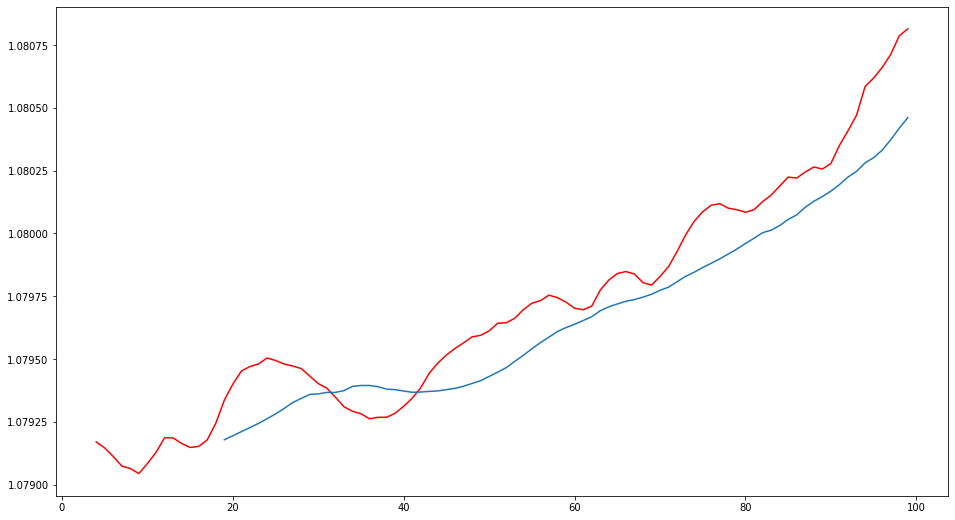

In [ ]:
sma_fast = 5
sma_slow = 20
signal = []
bars = mt5.copy_rates_from_pos('EURUSD', mt5.TIMEFRAME_M1, 0, 100)
bars_df = pd.DataFrame(bars)

fast_line = ta.SMA(bars_df.close, sma_fast)
slow_line = ta.SMA(bars_df.close, sma_slow)
 #MACD
Macd = ta.MACD(bars_df.close)
EMA_fast = ta.EMA(bars_df.close, 12)
EMA_slow = ta.EMA(bars_df.close, 26)
dif = EMA_fast - EMA_slow
macd = ta.EMA(dif, 9)



plt.figure(figsize=(16, 9))

plt.plot(fast_line, label='Close Price', alpha=1, color='red')
plt.plot(slow_line, label='Close Price', alpha=1)



